In [1]:
from pandas import read_csv
from statistics import mean, median
import seaborn as sns
import matplotlib.pyplot as plt

## Set the theme and figure size

In [2]:
def theme():
    sns.set(style="ticks")
    x = 1
    sns.set(rc={'figure.figsize': (15 / x, 10 / x)}, font_scale = 2.5 / x)


theme()

## Load cleaned data

In [3]:
g = read_csv('data/cleaned_answers.csv')
g.head(2)

,Unnamed: 0,index,Timestamp,sex,age,place_of_residence,is_polish_scout,scouting_organization,years_in_scouting,is_instructor,...,MIT_tick_jump_score,MIT_waiting_boreliosis_score,MIT_safe_score,MIT_summer_tick_score,MIT_part_tick_score,MIT_city_score,MIT_clock_score,total_score_without_images,total_score_with_images,score_as_percent
0,0,0,2018/04/27 1:36:27 PM GMT+2,Kobieta,17,Miasto powyżej 100 tys. mieszkańców,True,ZHP,11.0,True,...,1,1,1,1,1,1,1,26.2,26.2,90.344828
1,1,1,2018/04/27 1:43:31 PM GMT+2,Kobieta,18,Miasto powyżej 100 tys. mieszkańców,True,ZHP,5.0,True,...,1,1,0,1,1,1,0,22.9,22.9,78.965517


## Demographic statistics

In [4]:
scouts = g[g.is_polish_scout]
not_scouts = g[g.is_polish_scout == False]

In [5]:
h_mean = mean(scouts['total_score_without_images'])
nh_mean = mean(not_scouts['total_score_without_images'])
g_mean = mean(g['total_score_without_images'])
h_mean, nh_mean, g_mean

(23.537135720233138, 22.204674220963174, 22.686833383549263)

In [6]:
g.place_of_residence.value_counts()

Miasto powyżej 100 tys. mieszkańców     1094
Wieś                                    1016
Miasto do 50 tys. mieszkańców            765
Miasto od 50 do 100 tys. mieszkańców     444
Name: place_of_residence, dtype: int64

### Number of valid participants

In [7]:
participants_n = len(g)
participants_n

3319

### Number of women

In [8]:
g.is_women.describe()

count     3319
unique       2
top       True
freq      2650
Name: is_women, dtype: object

In [9]:
len(g[g.is_women])

2650

Majority participants were women

In [10]:
f'{round((len(g[g.is_women])/len(g))*100, 2)}% of participants were women.'

'79.84% of participants were women.'

### Number of scouts

In [11]:
g.is_polish_scout.describe()

count      3319
unique        2
top       False
freq       2118
Name: is_polish_scout, dtype: object

In [12]:
len(g[g.is_polish_scout])

1201

Only about 1/3 of participants were scouts

In [13]:
f'{round((len(g[g.is_polish_scout])/len(g))*100, 2)}% of participants were scouts.'

'36.19% of participants were scouts.'

### Age of participants

In [14]:
f'Mean age of all participants was: {round(mean(g.age), 2)} years.'

'Mean age of all participants was: 18.22 years.'

In [15]:
f'Median age of all participants was: {median(g.age)} years.'

'Median age of all participants was: 18 years.'

Mean and median age of participants are comparable so I expect little skew in the age distribution.

In [16]:
s = g.age.std()

Assuming that age distribution is normal I would expect 95% of participants to be in this age group:

In [17]:
mean(g.age) - 2 * s, mean(g.age) + 2 * s

(15.458138118576665, 20.980548232733973)

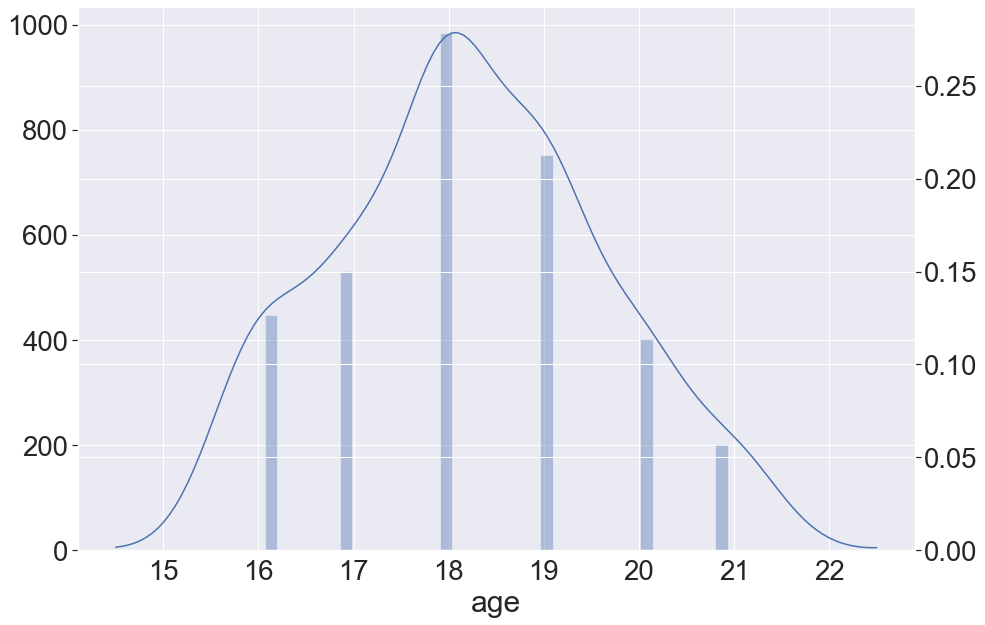

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.distplot(g.age, kde=False, ax=ax1, hist_kws={'rwidth': 0.5})
sns.distplot(g.age, hist=False, ax=ax2, kde_kws={'bw': .5});